In [3]:
# Core libraries
import numpy as np
import pandas as pd
import calendar

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import altair_ally as aly

# Time series analysis
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, seasonal_decompose, SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Forecasting models
# from pmdarima import auto_arima

# ML models
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Preprocessing and pipelines
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

# Model evaluation and cross-validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, cross_validate, GridSearchCV
)
import shap 

# Optimization
from scipy.optimize import minimize

# sktime
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ExpandingWindowSplitter
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon

%matplotlib inline

#### Read in data from excel workbook

In [4]:
excel_df = pd.read_excel('/Users/alexwong/Desktop/little_picses/LP_data.xlsx', sheet_name='Sheet2')
excel_df[excel_df.select_dtypes(include='number').columns] = excel_df.select_dtypes(include='number').round(2)

#### Read in weather data downloaded from https://vancouver.weatherstats.ca/

In [5]:
van_weather_df = pd.read_csv('/Users/alexwong/Desktop/little_picses/restaurant_sales_forecast/data/raw/weatherstats_vancouver_daily.csv')
van_weather_df['date'] = pd.to_datetime(van_weather_df['date'])

#### Filter dates that have corresponding sales data

In [6]:
start_date = excel_df['date'].min()
end_date = excel_df['date'].max()
van_weather_df = van_weather_df[(van_weather_df['date'] >= start_date) & 
               (van_weather_df['date'] <= end_date)
               ]
van_weather_df = van_weather_df.iloc[::-1] #flip the order with the most recent date at the bottom


In [7]:
## filtering for weather columns that we will use for the modelling
weather_columns_for_model = ['date','avg_temperature', 'rain', 'snow', 'avg_cloud_cover_8']

In [8]:
## joining the weather data to our dataset
combined_df = pd.merge(excel_df, van_weather_df[weather_columns_for_model], on='date', how='left')


In [9]:
def is_long_weekend(type_of_days):

    is_long_weekend_list = [False] * len(type_of_days)

    for i ,day in enumerate(type_of_days):

        if day == 'Holiday':
            prev_day = type_of_days[i-1] if i > 0 else None
            next_day = type_of_days[i+1] if i < len(type_of_days) - 1 else None 
            
            if prev_day == 'Weekend':
                is_long_weekend_list[i] = True
                is_long_weekend_list[i-1] = True
                is_long_weekend_list[i-2] = True
            
            if next_day == 'Weekend':
                is_long_weekend_list[i] = True
                is_long_weekend_list[i+1] = True
                is_long_weekend_list[i+2] = True
    
    return pd.Series(is_long_weekend_list, name='is_long_weekend')

In [10]:
def is_holiday(dates):

    holidays = dates.apply(lambda day: day == 'Holiday')

    return holidays

In [11]:
def is_HCF(dates, start, end):

    start = pd.Timestamp(start)
    end = pd.Timestamp(end)

    HCF_days = dates.apply(lambda day: start <= day <= end)
    HCF_days.name = 'is_HCF'

    return HCF_days

In [12]:
def has_pop_up(dates, pop_up_days):

    pop_up_days_dt = pd.to_datetime(pop_up_days)

    have_pop_up = dates.apply(lambda day: day in pop_up_days_dt)
    have_pop_up.name = 'has_pop_up'

    return have_pop_up

In [16]:
pop_up_days = [
    '2024-11-16',
    '2024-11-17',
    '2024-11-23',
    '2024-12-28',
    '2024-12-29',
    '2025-01-25',
    '2025-01-26',
    '2025-03-01',
    '2025-03-02',
    '2025-03-08',
    '2025-03-09',
    '2025-03-15',
    '2025-03-16',
    '2025-03-22',
    '2025-03-23',
    '2025-03-29',
    '2025-03-30',
    '2025-03-30',
    '2025-04-05',
    '2025-04-06',
    '2025-04-12',
    '2025-04-13',
    '2025-04-18',
    '2025-04-19',
    '2025-04-20',
    '2025-04-21',
    '2025-04-26',
    '2025-04-27',
    '2025-05-03',
    '2025-05-04',
]

In [17]:
def get_season(dates: pd.Series) -> pd.Series:
    """
    Given a Series of datetime objects, return a Series with the season for each date.
    Seasons are based on meteorological seasons in the Northern Hemisphere.
    """
    def season_of_date(date):
        month = date.month
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    return dates.apply(season_of_date).rename("season")

In [14]:
combined_df.loc[combined_df['note'] == 'Outage', 'type_of_day'] = 'Unusual'

In [18]:
combined_df['is_long_weekend'] = is_long_weekend(combined_df['type_of_day'])
combined_df['is_HCF'] = is_HCF(combined_df['date'], '2025-01-18', '2025-02-14')
combined_df['has_pop_up'] = has_pop_up(combined_df['date'], pop_up_days)
combined_df['is_holiday'] = is_holiday(combined_df['type_of_day'])
combined_df['season'] = get_season(combined_df['date'])
combined_df['day_of_week'] = combined_df['date'].dt.day_name()

## set sales of unusual days as average of usual days 
combined_df.loc[combined_df['type_of_day'] == 'Unusual', 'total_sales_normalized'] = combined_df.loc[(combined_df['type_of_day'] != 'Unusual') & (combined_df['day_of_week'] == 'Monday'), 'total_sales_normalized'].mean()

combined_df.loc[combined_df['type_of_day'] == 'Unusual', 'item_A_sales'] = combined_df.loc[(combined_df['type_of_day'] != 'Unusual') & (combined_df['day_of_week'] == 'Monday'), 'item_A_sales'].mean()
combined_df.loc[combined_df['type_of_day'] == 'Unusual', 'item_B_sales'] = combined_df.loc[(combined_df['type_of_day'] != 'Unusual') & (combined_df['day_of_week'] == 'Monday'), 'item_B_sales'].mean()
combined_df.loc[combined_df['type_of_day'] == 'Unusual', 'item_C_sales'] = combined_df.loc[(combined_df['type_of_day'] != 'Unusual') & (combined_df['day_of_week'] == 'Monday'), 'item_C_sales'].mean()

combined_df['is_long_weekend'] = pd.Categorical(combined_df['is_long_weekend'], categories=[False, True])
combined_df['is_HCF'] = pd.Categorical(combined_df['is_HCF'], categories=[False, True])
#combined_df['type_of_day'] = pd.Categorical(combined_df['type_of_day'], categories=['Weekday', 'Friday', 'Weekend', 'Holiday'])
combined_df['day_of_week'] = pd.Categorical(combined_df['day_of_week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
combined_df['has_pop_up'] = pd.Categorical(combined_df['has_pop_up'], categories=[False, True])
combined_df['season'] = pd.Categorical(combined_df['season'], categories=['Winter', 'Spring', 'Summer', 'Fall'])
combined_df['log_total_sales_normalized'] = np.log(combined_df['total_sales_normalized'])
combined_df['log_item_A_sales'] = np.log(combined_df['item_A_sales'].replace(0, 1e-6))
combined_df['log_item_B_sales'] = np.log(combined_df['item_B_sales'].replace(0, 1e-6))
combined_df['log_item_C_sales'] = np.log(combined_df['item_C_sales'].replace(0, 1e-6))


In [17]:
combined_df.set_index('date', inplace=True)

In [18]:
total_sales_df = combined_df[['hours_opened', 'avg_temperature', 'rain', 'snow', 
       'avg_cloud_cover_8', 'is_long_weekend', 'is_HCF', 'has_pop_up',
       'season', 'day_of_week', 'is_holiday', 'total_sales_normalized']]

item_A_df = combined_df[['hours_opened', 'avg_temperature', 'rain', 'snow', 
       'avg_cloud_cover_8', 'is_long_weekend', 'is_HCF', 'has_pop_up',
       'season', 'day_of_week', 'is_holiday', 'item_A_sales']]

item_B_df = combined_df[['hours_opened', 'avg_temperature', 'rain', 'snow', 
       'avg_cloud_cover_8', 'is_long_weekend', 'is_HCF', 'has_pop_up',
       'season', 'day_of_week', 'is_holiday', 'item_B_sales']]

item_C_df = combined_df[['hours_opened', 'avg_temperature', 'rain', 'snow', 
       'avg_cloud_cover_8', 'is_long_weekend', 'is_HCF', 'has_pop_up',
       'season', 'day_of_week', 'is_holiday', 'item_C_sales']]

log_total_sales_df = combined_df[['hours_opened', 'avg_temperature', 'rain', 'snow', 
       'avg_cloud_cover_8', 'is_long_weekend', 'is_HCF', 'has_pop_up',
       'season', 'day_of_week', 'is_holiday', 'log_total_sales_normalized']]

log_item_A_df = combined_df[['hours_opened', 'avg_temperature', 'rain', 'snow', 
       'avg_cloud_cover_8', 'is_long_weekend', 'is_HCF', 'has_pop_up',
       'season', 'day_of_week', 'is_holiday', 'log_item_A_sales']]

log_item_B_df = combined_df[['hours_opened', 'avg_temperature', 'rain', 'snow', 
       'avg_cloud_cover_8', 'is_long_weekend', 'is_HCF', 'has_pop_up',
       'season', 'day_of_week', 'is_holiday', 'log_item_B_sales']]

log_item_C_df = combined_df[['hours_opened', 'avg_temperature', 'rain', 'snow', 
       'avg_cloud_cover_8', 'is_long_weekend', 'is_HCF', 'has_pop_up',
       'season', 'day_of_week', 'is_holiday', 'log_item_C_sales']]

In [20]:
total_sales_df.to_csv('/Users/alexwong/Desktop/little_picses/restaurant_sales_forecast/data/processed/total_sales_df')

#### Exploratory data analysis

In [174]:
aly.dist(log_total_sales_df)

alt.ConcatChart(...)

In [175]:
round(total_sales_df.describe(),2)

,hours_opened,avg_temperature,rain,snow,avg_cloud_cover_8,total_sales_normalized
count,342.00,342.00,342.00,342.00,342.00,342.00
mean,11.26,10.48,3.35,0.06,4.66,2977.30
std,1.03,5.94,6.97,0.55,1.92,1256.88
min,0.00,-4.95,0.00,0.00,0.00,699.06
25%,11.00,6.50,0.00,0.00,4.00,1890.62
50%,11.00,10.05,0.00,0.00,4.50,2858.77
75%,12.00,15.52,4.00,0.00,6.00,3774.54
max,12.00,21.95,67.10,5.80,8.00,7444.84


In [176]:
round(item_A_df.describe(),2)

,hours_opened,avg_temperature,rain,snow,avg_cloud_cover_8,item_A_sales
count,342.00,342.00,342.00,342.00,342.00,342.00
mean,11.26,10.48,3.35,0.06,4.66,1186.97
std,1.03,5.94,6.97,0.55,1.92,473.92
min,0.00,-4.95,0.00,0.00,0.00,375.55
25%,11.00,6.50,0.00,0.00,4.00,802.10
50%,11.00,10.05,0.00,0.00,4.50,1101.42
75%,12.00,15.52,4.00,0.00,6.00,1495.42
max,12.00,21.95,67.10,5.80,8.00,3810.20


In [177]:
round(item_B_df.describe(),2)

,hours_opened,avg_temperature,rain,snow,avg_cloud_cover_8,item_B_sales
count,342.00,342.00,342.00,342.00,342.00,342.00
mean,11.26,10.48,3.35,0.06,4.66,1254.74
std,1.03,5.94,6.97,0.55,1.92,686.50
min,0.00,-4.95,0.00,0.00,0.00,189.80
25%,11.00,6.50,0.00,0.00,4.00,670.22
50%,11.00,10.05,0.00,0.00,4.50,1124.10
75%,12.00,15.52,4.00,0.00,6.00,1641.29
max,12.00,21.95,67.10,5.80,8.00,3633.71


### Average sales and variance by day of the week

In [178]:
pd.DataFrame(total_sales_df.groupby('day_of_week')['total_sales_normalized'].agg(
    mean_sales='mean',
    sd_sales='std'
).reset_index()).round(2)

/var/folders/bs/1zcbgx297zz5st6vwh5yrhpw0000gn/T/ipykernel_63936/2477955852.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,day_of_week,mean_sales,sd_sales
0,Monday,2361.05,908.58
1,Tuesday,2027.96,732.91
2,Wednesday,2250.15,755.44
3,Thursday,2254.85,669.48
4,Friday,3452.23,875.81
5,Saturday,4426.90,1075.65
6,Sunday,4077.68,972.67


### Correlation - total sales

In [179]:
total_sales_df.corr(numeric_only=True).round(2)

,hours_opened,avg_temperature,rain,snow,avg_cloud_cover_8,is_holiday,total_sales_normalized
hours_opened,1.00,0.07,-0.03,-0.03,-0.06,-0.04,0.35
avg_temperature,0.07,1.00,-0.06,-0.20,-0.23,0.01,0.41
rain,-0.03,-0.06,1.00,-0.00,0.47,0.07,-0.10
snow,-0.03,-0.20,-0.00,1.00,0.05,-0.02,-0.11
avg_cloud_cover_8,-0.06,-0.23,0.47,0.05,1.00,-0.00,-0.18
is_holiday,-0.04,0.01,0.07,-0.02,-0.00,1.00,0.11
total_sales_normalized,0.35,0.41,-0.10,-0.11,-0.18,0.11,1.00


### Correlation - item A

- Least correlated with weather compared to item B and item C 
- Strongest jump in sales during holidays

In [180]:
item_A_df.corr(numeric_only=True).round(2)

,hours_opened,avg_temperature,rain,snow,avg_cloud_cover_8,is_holiday,item_A_sales
hours_opened,1.00,0.07,-0.03,-0.03,-0.06,-0.04,0.30
avg_temperature,0.07,1.00,-0.06,-0.20,-0.23,0.01,0.23
rain,-0.03,-0.06,1.00,-0.00,0.47,0.07,0.01
snow,-0.03,-0.20,-0.00,1.00,0.05,-0.02,-0.09
avg_cloud_cover_8,-0.06,-0.23,0.47,0.05,1.00,-0.00,0.02
is_holiday,-0.04,0.01,0.07,-0.02,-0.00,1.00,0.14
item_A_sales,0.30,0.23,0.01,-0.09,0.02,0.14,1.00


### Correlation - item B (soft serve)

- Strongest correlation with weather 

In [181]:
item_B_df.corr(numeric_only=True).round(2)

,hours_opened,avg_temperature,rain,snow,avg_cloud_cover_8,is_holiday,item_B_sales
hours_opened,1.00,0.07,-0.03,-0.03,-0.06,-0.04,0.34
avg_temperature,0.07,1.00,-0.06,-0.20,-0.23,0.01,0.60
rain,-0.03,-0.06,1.00,-0.00,0.47,0.07,-0.17
snow,-0.03,-0.20,-0.00,1.00,0.05,-0.02,-0.13
avg_cloud_cover_8,-0.06,-0.23,0.47,0.05,1.00,-0.00,-0.30
is_holiday,-0.04,0.01,0.07,-0.02,-0.00,1.00,0.08
item_B_sales,0.34,0.60,-0.17,-0.13,-0.30,0.08,1.00


### Correlation - item C

In [182]:
item_C_df.corr(numeric_only=True).round(2)

,hours_opened,avg_temperature,rain,snow,avg_cloud_cover_8,is_holiday,item_C_sales
hours_opened,1.00,0.07,-0.03,-0.03,-0.06,-0.04,0.27
avg_temperature,0.07,1.00,-0.06,-0.20,-0.23,0.01,0.35
rain,-0.03,-0.06,1.00,-0.00,0.47,0.07,-0.03
snow,-0.03,-0.20,-0.00,1.00,0.05,-0.02,-0.14
avg_cloud_cover_8,-0.06,-0.23,0.47,0.05,1.00,-0.00,-0.09
is_holiday,-0.04,0.01,0.07,-0.02,-0.00,1.00,0.09
item_C_sales,0.27,0.35,-0.03,-0.14,-0.09,0.09,1.00


## Baseline regression model

In [183]:
def train_test(X_train, y_train, X_test, y_test, preprocessor, model, log=False):

    x_train_transformed = preprocessor.fit_transform(X_train)
    x_test_transformed = preprocessor.transform(X_test)

    model.fit(x_train_transformed, y_train)
    y_pred = model.predict(x_test_transformed)
    
    if log:
        mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
    else:
        mae = mean_absolute_error(y_test, y_pred)
        
    return mae, y_pred, preprocessor, model

In [184]:
result_dict = {}

In [206]:
numerical_features = ['hours_opened', 'avg_temperature', 'rain', 'snow', 'avg_cloud_cover_8']
categorical_features = ['is_long_weekend', 'is_HCF', 'has_pop_up', 'season', 'day_of_week', 'is_holiday']
category_orders = [
    [False, True],  # is_long_weekend
    [False, True],  # is_HCF
    [False, True],  # has_pop_up
    ['Winter', 'Spring', 'Summer', 'Fall'],  # season
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],  # day_of_week
    [False, True]  # is_holiday
]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)

lr_pipe = make_pipeline(preprocessor, LinearRegression())

In [207]:
train_df = total_sales_df.iloc[:-60,]
test_df = total_sales_df.iloc[-60:,]

X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [208]:
scoring_metric = {
    'neg_MAE':'neg_mean_absolute_error',
}

In [209]:
lr = LinearRegression()
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)

lr_mae, lr_pred, fitted_preprocessor, trained_lr = train_test(X_train, y_train, X_test, y_test, preprocessor, lr)

In [210]:
columns = (preprocessor.named_transformers_['onehotencoder'].get_feature_names_out().tolist() + 
           preprocessor.named_transformers_['standardscaler'].get_feature_names_out().tolist()) 

lr_coef = pd.DataFrame({
    'features': columns,
    'coefficient': lr.coef_
})

lr_coef.sort_values(by='coefficient', ascending=False)

,features,coefficient
10,day_of_week_Saturday,2244.119434
11,day_of_week_Sunday,1958.013150
12,is_holiday_True,1571.687125
4,season_Summer,1329.101318
9,day_of_week_Friday,1318.915355
3,season_Spring,539.026267
1,is_HCF_1.0,388.571425
0,is_long_weekend_1.0,317.348377
14,avg_temperature,111.137581
7,day_of_week_Wednesday,97.309878


In [211]:
print(lr_mae)

293.0685370527435


In [212]:
y_train_for_plot = pd.DataFrame(y_train).assign(label='train')
y_test_for_plot = pd.DataFrame(y_test).assign(label='test')
lr_pred_for_plot = pd.DataFrame(lr_pred, columns=['total_sales_normalized'], index=y_test.index).assign(label='linear_regression')

px.line(pd.concat((y_train_for_plot, y_test_for_plot, lr_pred_for_plot)), 
        y="total_sales_normalized",
        color='label', 
        title='prediction results - linear regression')

In [213]:
comparison_df = pd.DataFrame({
    'test': y_test,
    'lr_pred': lr_pred,
}, index=y_test.index)

comparison_df['lr_error'] = comparison_df['lr_pred'] - comparison_df['test']
comparison_df['day_of_week'] = comparison_df.index.day_name()
comparison_df[comparison_df.select_dtypes('number').columns] = comparison_df[comparison_df.select_dtypes(include='number').columns] = comparison_df.select_dtypes(include='number').astype('int')

comparison_df.groupby('day_of_week').mean().round(2)

,test,lr_pred,lr_error
day_of_week,,,
Friday,4033.50,3688.50,-344.62
Monday,2227.56,2379.33,151.89
Saturday,4827.62,4498.50,-328.62
Sunday,4138.38,4166.38,28.00
Thursday,2495.44,2389.00,-106.22
Tuesday,2124.00,2071.89,-51.78
Wednesday,2347.56,2223.00,-124.22


### Regression - log sales

In [192]:
train_df = log_total_sales_df.iloc[:-60,]
test_df = log_total_sales_df.iloc[-60:,]

X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1] 

In [193]:
lr = LinearRegression()
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)

lr_mae, lr_pred, fitted_preprocessor, trained_lr = train_test(X_train, y_train, X_test, y_test, preprocessor, lr, log=True)

In [194]:
columns = (preprocessor.named_transformers_['onehotencoder'].get_feature_names_out().tolist() + 
           preprocessor.named_transformers_['standardscaler'].get_feature_names_out().tolist()) 

lr_coef = pd.DataFrame({
    'features': columns,
    'coefficient': np.exp(lr.coef_)
})

lr_coef.sort_values(by='coefficient', ascending=False)

,features,coefficient
10,day_of_week_Saturday,2.000345
11,day_of_week_Sunday,1.899707
12,is_holiday_True,1.802355
9,day_of_week_Friday,1.591515
4,season_Summer,1.494347
3,season_Spring,1.199953
1,is_HCF_1.0,1.191922
2,has_pop_up_1.0,1.096256
0,is_long_weekend_1.0,1.088984
14,avg_temperature,1.077180


In [195]:
lr_mae

375.4728160803235

In [196]:
y_train_for_plot = pd.DataFrame(np.exp(y_train)).assign(label='train')
y_test_for_plot = pd.DataFrame(np.exp(y_test)).assign(label='test')
lr_pred_for_plot = pd.DataFrame(np.exp(lr_pred), columns=['log_total_sales_normalized'], index=y_test.index).assign(label='linear_regression')

px.line(pd.concat((y_train_for_plot, y_test_for_plot, lr_pred_for_plot)), 
        y="log_total_sales_normalized",
        color='label', 
        title='prediction results - linear regression - log sales')

### Regression - Item A only 

In [197]:
train_df = item_A_df.iloc[:-60,]
test_df = item_A_df.iloc[-60:,]

X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1] 

lr = LinearRegression()
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)

lr_mae, lr_pred, fitted_preprocessor, trained_lr = train_test(X_train, y_train, X_test, y_test, preprocessor, lr, log=False)


In [198]:
lr_mae

208.18171318846098

In [199]:
y_train_for_plot = pd.DataFrame(y_train).assign(label='train')
y_test_for_plot = pd.DataFrame(y_test).assign(label='test')
lr_pred_for_plot = pd.DataFrame(lr_pred, columns=['item_A_sales'], index=y_test.index).assign(label='linear_regression')

px.line(pd.concat((y_train_for_plot, y_test_for_plot, lr_pred_for_plot)), 
        y="item_A_sales",
        color='label', 
        title='prediction results - linear regression')

### Regression - Item B only 

In [200]:
train_df = item_B_df.iloc[:-60,]
test_df = item_B_df.iloc[-60:,]

X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1] 

lr = LinearRegression()
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)

lr_mae, lr_pred, fitted_preprocessor, trained_lr = train_test(X_train, y_train, X_test, y_test, preprocessor, lr, log=False)

In [201]:
lr_mae

176.27286819103782

In [203]:
y_train_for_plot = pd.DataFrame(y_train).assign(label='train')
y_test_for_plot = pd.DataFrame(y_test).assign(label='test')
lr_pred_for_plot = pd.DataFrame(lr_pred, columns=['item_B_sales'], index=y_test.index).assign(label='linear_regression')

px.line(pd.concat((y_train_for_plot, y_test_for_plot, lr_pred_for_plot)), 
        y="item_B_sales",
        color='label', 
        title='prediction results - linear regression')

## Random forest regressor

In [214]:
rf = RandomForestRegressor(random_state=123)
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)

rf_mae, rf_pred, fitted_preprocessor, trained_rf = train_test(X_train, y_train, X_test, y_test, preprocessor, rf)

In [215]:
rf_mae

498.7177463768116

In [216]:
rf_pred_for_plot = pd.DataFrame(rf_pred, columns=['total_sales_normalized'], index=y_test.index).assign(label='random_forest')

In [95]:
px.line(pd.concat((y_train_for_plot, y_test_for_plot, rf_pred_for_plot)), 
        y="total_sales_normalized",
        color='label', 
        title='prediction results - random forest')

#### Hyperparameter tuning

In [81]:
RandomForestRegressor(random_state=123)

RandomForestRegressor(random_state=123)

In [82]:
y_train = pd.to_numeric(y_train, errors='coerce')

In [83]:
param_grid = {
    'randomforestregressor__n_estimators': [10, 50, 100],
    'randomforestregressor__max_features': ['sqrt', 'log2'],
    'randomforestregressor__max_depth': [None, 5, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(criterion='absolute_error',random_state=123)
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)
rf_pipe = make_pipeline(preprocessor, rf)

grid_search = GridSearchCV(rf_pipe, param_grid, n_jobs=-1, cv=5, return_train_score = True, scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(categories=[[False,
                                                                                                    True],
                                                                                                   [False,
                                                                                                    True],
                                                                                                   [False,
                                                                                                    True],
                                                                                                   ['Winter',
                                                                                                    'Spring',
                                                                                                    'Summer',
                                                                                                    'Fall'],
                                                                                                   ['Monday',
                                                                                                    'Tuesday',
                                                                                                    'Wednesday',
                                                                                                    'Thursday',
                                                                                                    'Friday',
                                                                                                    'Saturday',
                                                                                                    'Sunday'],
                                                                                                   [False,
                                                                                                    True]],
                                                                                       drop='first'),
                                                                         ['is_long_weekend',
                                                                          'is_HCF',
                                                                          'has_p...
                                                              random_state=123))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 5, 10, 20],
                         'randomforestregressor__max_features': ['sqrt',
                                                                 'log2'],
                         'randomforestregressor__min_samples_leaf': [1, 2, 4],
                         'randomforestregressor__min_samples_split': [2, 5, 10],
                         'randomforestregressor__n_estimators': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [85]:
pd.DataFrame(grid_search.cv_results_)[

    ['rank_test_score',
     'mean_test_score',
     'mean_train_score',
     'mean_fit_time',
     'mean_score_time',
     'param_randomforestregressor__max_depth', 
     'param_randomforestregressor__max_features', 
     'param_randomforestregressor__min_samples_leaf', 
     'param_randomforestregressor__min_samples_split', 
     'param_randomforestregressor__n_estimators',
    ]
].set_index('rank_test_score').sort_index()

,mean_test_score,mean_train_score,mean_fit_time,mean_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__max_features,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__min_samples_split,param_randomforestregressor__n_estimators
rank_test_score,,,,,,,,,
1,-548.298356,-336.843336,0.017556,0.002936,20,sqrt,1,10,10
1,-548.298356,-336.843336,0.027852,0.002960,20,log2,1,10,10
1,-548.298356,-336.843336,0.018287,0.003388,None,log2,1,10,10
1,-548.298356,-336.843336,0.015477,0.002216,None,sqrt,1,10,10
5,-551.862910,-216.827618,0.119087,0.006772,10,log2,1,2,100
...,...,...,...,...,...,...,...,...,...
211,-644.040332,-456.543865,0.013453,0.002380,5,sqrt,4,5,10
211,-644.040332,-456.543865,0.013395,0.002088,5,log2,4,2,10
211,-644.040332,-456.543865,0.013679,0.002425,5,log2,4,5,10


#### SHAP

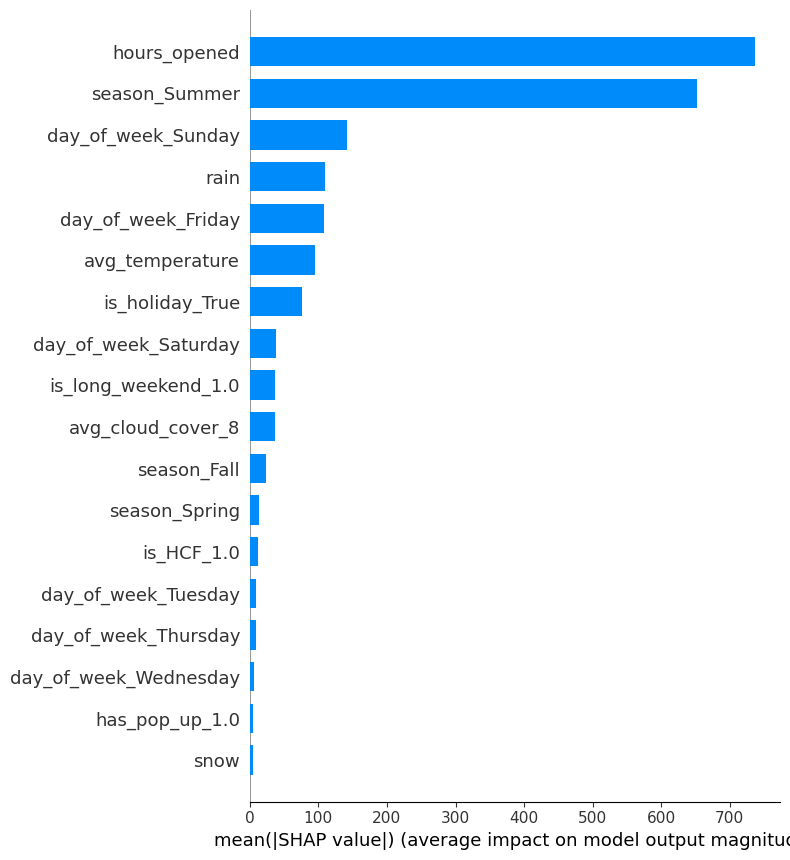

In [86]:
explainer = shap.TreeExplainer(trained_rf)
observations = pd.DataFrame(preprocessor.transform(X_train), columns=columns)
shap_values = explainer.shap_values(observations)
shap.summary_plot(shap_values, observations, plot_type='bar')


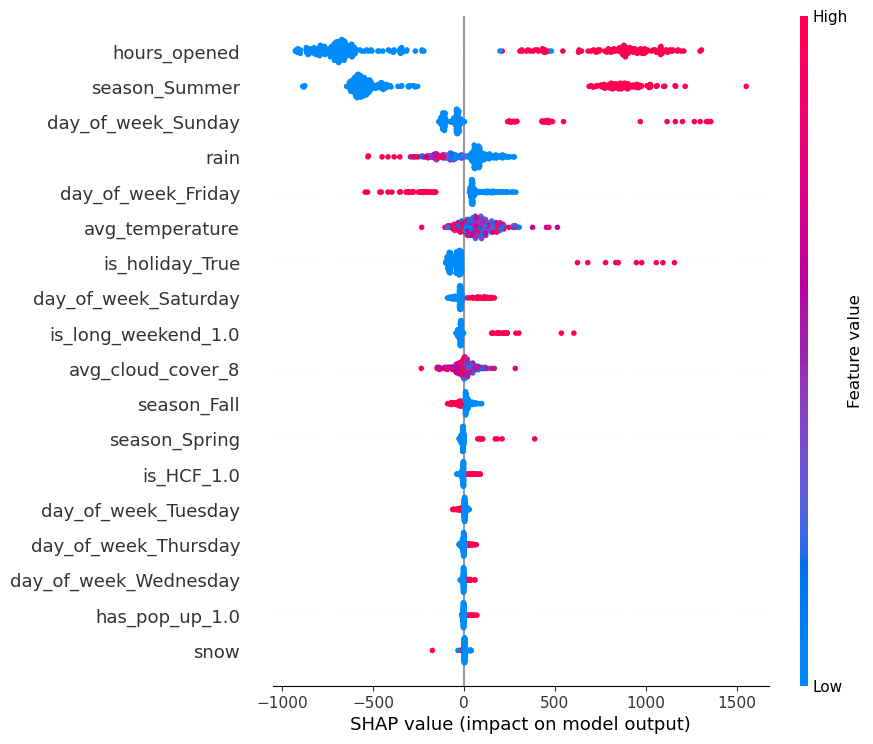

In [88]:
explanation = explainer(observations)
shap.plots.beeswarm(explanation, max_display=50)

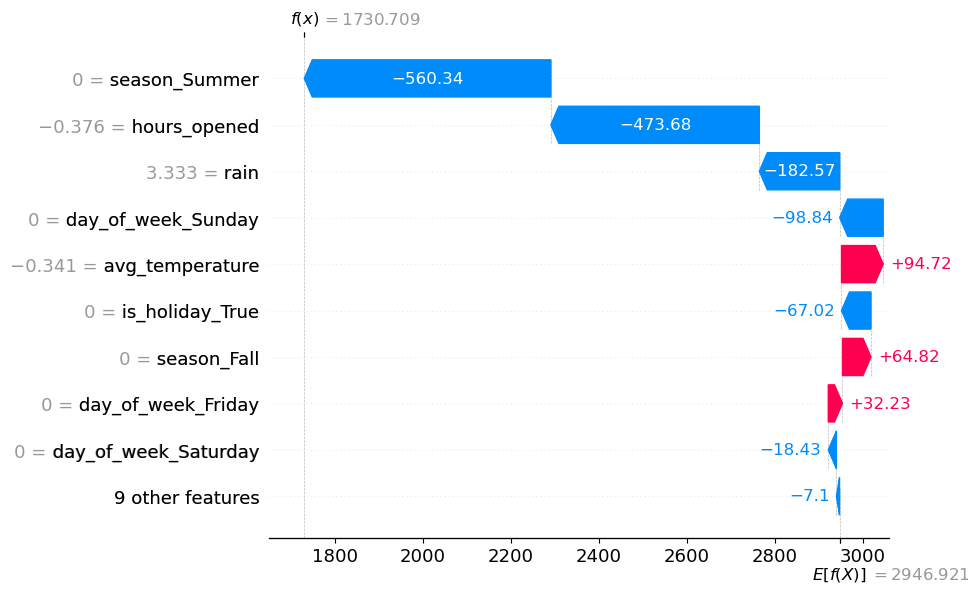

In [89]:
shap.plots.waterfall(explanation[200, :])

#### XGBoost regressor 

In [217]:
xgb = XGBRegressor(random_state=123)
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)

xgb_mae, xgb_pred, fitted_preprocessor, trained_xgb = train_test(X_train, y_train, X_test, y_test, preprocessor, xgb)

In [218]:
xgb_mae

448.67095800781254

In [219]:
xgb_pred_for_plot = pd.DataFrame(xgb_pred,  columns=['total_sales_normalized'], index=y_test.index).assign(label='XGboost')

In [220]:
px.line(pd.concat((y_train_for_plot, y_test_for_plot, xgb_pred_for_plot)), 
        y="total_sales_normalized",
        color='label', 
        title='prediction results - XGboost')

#### Hyperparameter tuning

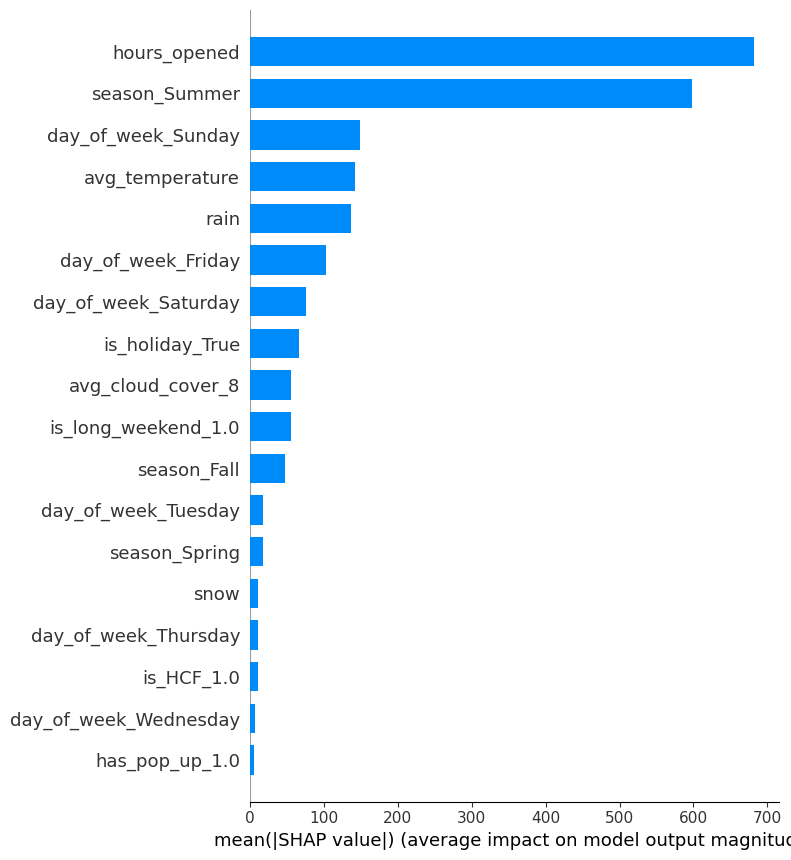

In [91]:
explainer = shap.TreeExplainer(trained_xgb)
observations = pd.DataFrame(preprocessor.transform(X_train), columns=columns)
shap_values = explainer.shap_values(observations)
shap.summary_plot(shap_values, observations, plot_type='bar')

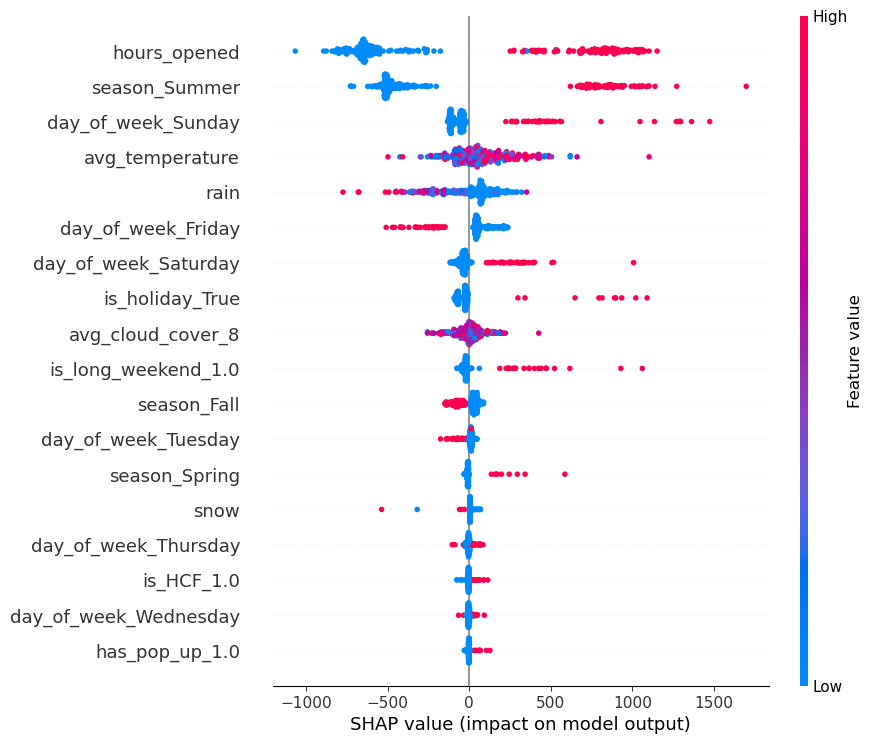

In [92]:
explanation = explainer(observations)
shap.plots.beeswarm(explanation, max_display=50)

In [221]:
comparison_df = pd.DataFrame({
    'test': y_test,
    'lr_pred': lr_pred,
    'rf_pred': rf_pred,
    'xgb_pred': xgb_pred
}, index=y_test.index)

comparison_df['lr_error'] = comparison_df['lr_pred'] - comparison_df['test']
comparison_df['rf_error'] = comparison_df['rf_pred'] - comparison_df['test']
comparison_df['xgb_error'] = comparison_df['xgb_pred'] - comparison_df['test']
comparison_df['day_of_week'] = comparison_df.index.day_name()
comparison_df[comparison_df.select_dtypes('number').columns] = comparison_df[comparison_df.select_dtypes(include='number').columns] = comparison_df.select_dtypes(include='number').astype('int')

comparison_df.groupby('day_of_week').mean().round(2)

,test,lr_pred,rf_pred,xgb_pred,lr_error,rf_error,xgb_error
day_of_week,,,,,,,
Friday,4033.50,3688.50,3241.25,3377.62,-344.62,-791.62,-655.50
Monday,2227.56,2379.33,1963.33,2132.11,151.89,-263.89,-94.89
Saturday,4827.62,4498.50,4274.88,4458.50,-328.62,-552.38,-369.00
Sunday,4138.38,4166.38,4002.62,4108.38,28.00,-135.75,-30.12
Thursday,2495.44,2389.00,2061.11,2110.78,-106.22,-433.78,-384.33
Tuesday,2124.00,2071.89,1836.00,1975.22,-51.78,-287.78,-148.67
Wednesday,2347.56,2223.00,1878.22,2007.89,-124.22,-468.78,-339.44


#### Observations

- Linear regression doing the best currently 
  - Main benefits: Interpretibility, captures relationship pretty well 
  
- Underestimate Friday and Saturdays the most 



## Time Series

In [243]:
total_sales_df = combined_df[['total_sales_normalized']]
#total_sales_df.set_index('date', inplace=True)

item_A_sales_df = combined_df[['item_A_sales']]
#item_A_sales_df.set_index('date', inplace=True)

item_B_sales_df = combined_df[['item_B_sales']]
#item_B_sales_df.set_index('date', inplace=True)

item_C_sales_df = combined_df[['item_C_sales']]
#item_C_sales_df.set_index('date', inplace=True)

combined_sales_df = pd.concat([total_sales_df, item_A_sales_df, item_B_sales_df, item_C_sales_df], axis=1)

In [244]:
fig = px.line(combined_sales_df, title='Daily sales')


fig.add_vline(
    x=pd.to_datetime('2025-03-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Spring begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vline(
    x=pd.to_datetime('2024-12-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Winter begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vline(
    x=pd.to_datetime('2024-09-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Fall begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vrect(x0="2025-01-18", x1="2025-2-14", 
              annotation_text="HCF", annotation_position="top left",
              fillcolor="green", opacity=0.1, line_width=0)


fig.show()

In [245]:
combined_sales_resample = combined_sales_df.resample('W').mean()

fig = px.line(combined_sales_resample, title='Weekly sales')

fig.add_vline(
    x=pd.to_datetime('2025-03-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Spring begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vline(
    x=pd.to_datetime('2024-12-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Winter begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vline(
    x=pd.to_datetime('2024-09-01'),
    line_dash='dash',
    line_color='red',
    label=dict(
        text='Fall begins',
        textangle=0,
        textposition="end",
        xanchor='center'
))

fig.add_vrect(x0="2025-01-18", x1="2025-2-14", 
              annotation_text="HCF", annotation_position="top left",
              fillcolor="green", opacity=0.1, line_width=0)


fig.show()

In [246]:
decompose_model = seasonal_decompose(combined_df[["total_sales_normalized"]], model="additive", period=7)
trend = decompose_model.trend 
seasonal = decompose_model.seasonal
residuals = decompose_model.resid


decompose_df = pd.DataFrame(
    {"total_sales_normalized": combined_df['total_sales_normalized'],
     'trend': trend,
     'seasonal': seasonal,
     'residuals': residuals
    }
)

decompose_df.set_index(combined_df['date'], inplace=True)
decompose_df['day_of_week'] = decompose_df.index.day_name()
decompose_df

KeyError: 'date'

<Axes: title={'center': 'Seasonal differenced'}, xlabel='date'>

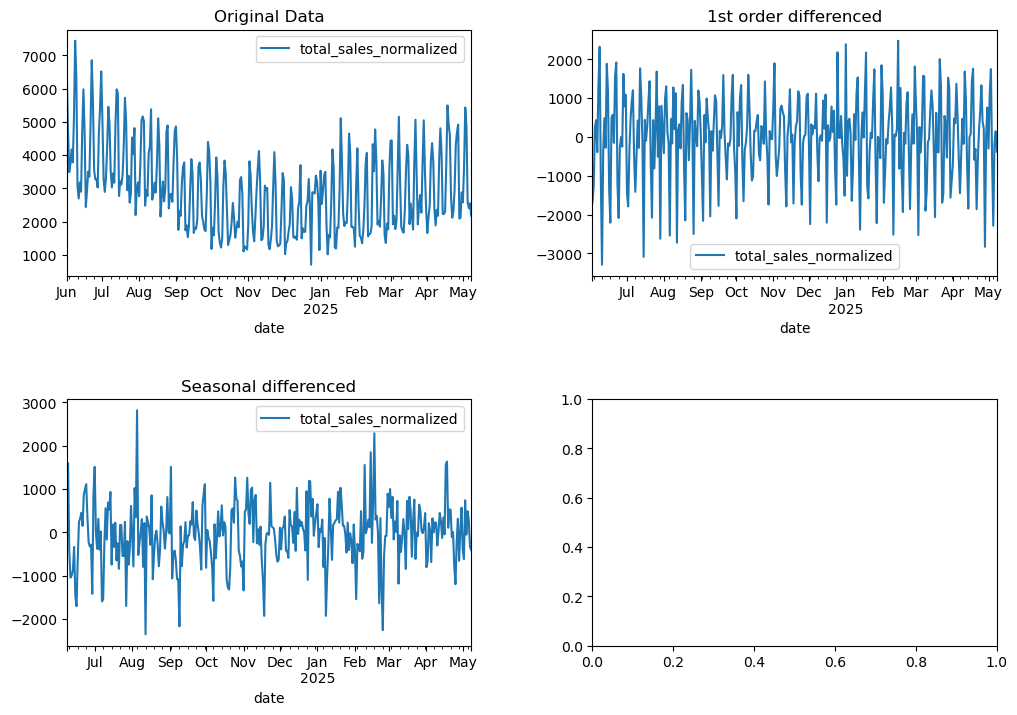

In [247]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

total_sales_df.plot(ax=axes[0,0], title='Original Data')

total_sales_diff = total_sales_df.diff().dropna() # 1st order diff
total_sales_diff.plot(ax=axes[0,1], title='1st order differenced')

total_sales_seasonal_diff = total_sales_df.diff(7).dropna()
total_sales_seasonal_diff.plot(ax=axes[1,0], title='Seasonal differenced')


In [248]:
result_adf = adfuller(total_sales_diff)

print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])

ADF Statistic: -7.849843
p-value: 0.000000


### SARIMA

In [249]:
y_ts = combined_df[['total_sales_normalized']]
y_train_ts = y_ts.iloc[0:-60].assign(Label = 'train')
y_valid_ts = y_ts.iloc[-60:].assign(Label = "test")

In [250]:
y_train_ts

,total_sales_normalized,Label
date,,
2024-06-01,6433.36,train
2024-06-02,4755.46,train
2024-06-03,3487.14,train
2024-06-04,3739.60,train
2024-06-05,4172.75,train
...,...,...
2025-03-05,1773.03,train
2025-03-06,2016.06,train
2025-03-07,3593.81,train


In [251]:
autoarima = auto_arima(y_train_ts['total_sales_normalized'], seasonal=True, m=7)
autoarima.get_params()

best_order = autoarima.get_params()['order']
best_seasonal_order = autoarima.get_params()['seasonal_order']

In [252]:
sarima_model = ARIMA(y_train_ts['total_sales_normalized'], order=best_order, seasonal_order=best_seasonal_order).fit()
sarima_forecast = pd.DataFrame({"total_sales_normalized":sarima_model.forecast(len(y_valid_ts)),
                               "Label":"SARIMA"})
sarima_forecast.index = y_valid_ts.index

/Users/alexwong/miniforge3/envs/mds574/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/alexwong/miniforge3/envs/mds574/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/alexwong/miniforge3/envs/mds574/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [253]:
px.line(pd.concat((y_train_ts, y_valid_ts, sarima_forecast)), y="total_sales_normalized", width=640, color="Label")

In [254]:
comparison = pd.DataFrame({
    'valid': y_valid_ts['total_sales_normalized'],
    'sarima': sarima_forecast['total_sales_normalized']
})
comparison['Error'] = comparison['sarima'] - comparison['valid'] 
comparison['day_of_week'] = comparison.index.day_name()
comparison


,valid,sarima,Error,day_of_week
date,,,,
2025-03-10,1847.790000,2207.428592,359.638592,Monday
2025-03-11,1722.520000,1601.039458,-121.480542,Tuesday
2025-03-12,1663.420000,1902.999244,239.579244,Wednesday
2025-03-13,2322.980000,1851.545853,-471.434147,Thursday
2025-03-14,3522.780000,2962.845889,-559.934111,Friday
2025-03-15,4308.540000,3946.685166,-361.854834,Saturday
2025-03-16,3984.710000,3669.605786,-315.104214,Sunday
2025-03-17,1922.030000,2019.772218,97.742218,Monday
2025-03-18,2543.940000,1635.185839,-908.754161,Tuesday


In [255]:
comparison.groupby('day_of_week').mean()


,valid,sarima,Error
day_of_week,,,
Friday,4034.015000,2869.860939,-1164.154061
Monday,2227.939227,1960.565857,-267.373370
Saturday,4828.250000,3857.197473,-971.052527
Sunday,4138.925000,3578.811685,-560.113315
Thursday,2495.896667,1755.774588,-740.122078
Tuesday,2124.556667,1551.219043,-573.337624
Wednesday,2348.074444,1780.250160,-567.824284


#### Notes 

- divide into 4 season blocks, do train/test within each block - regression
- SARIMAX - whole series 
- 1000 random train / test split -> look at RMSE 

- Question:
  - how to interpret when main variable is not significant but interaction affect is
  - how big should test set be if i only want to forecast 7 days ahead

#### Testing random train / test split for 1000 samples

In [ ]:
numerical_features = ['hours_opened', 'avg_temperature', 'rain', 'snow', 'avg_cloud_cover_8']
categorical_features = ['is_long_weekend', 'is_HCF', 'has_pop_up', 'season', 'day_of_week', 'is_holiday']
category_orders = [
    [False, True],  # is_long_weekend
    [False, True],  # is_HCF
    [False, True],  # has_pop_up
    ['Winter', 'Spring', 'Summer', 'Fall'],  # season
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],  # day_of_week
    [False, True]  # is_holiday
]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    ('passthrough', numerical_features)
)

lr_pipe = (preprocessor, LinearRegression())

In [ ]:
train_df, test_df = train_test_split(log_total_sales_df, test_size=0.1)

X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [ ]:
index = (preprocessor.named_transformers_['onehotencoder'].get_feature_names_out().tolist() + 
        preprocessor.named_transformers_['passthrough'].get_feature_names_out().tolist()
)

In [ ]:
n = 1000
result_list = []

for i in range(n):

    train_df, test_df = train_test_split(log_total_sales_df, test_size=0.1)

    X_train = train_df.iloc[:, :-1]
    y_train = train_df.iloc[:, -1]
    X_test = test_df.iloc[:, :-1]
    y_test = test_df.iloc[:, -1]

    x_train_transformed = preprocessor.fit_transform(X_train)
    x_test_transformed = preprocessor.transform(X_test)

    model = LinearRegression()
    model.fit(x_train_transformed, y_train)
    y_pred = model.predict(x_test_transformed)
    
    mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
    result_list.append(mae)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(result_list, bins=20, edgecolor='black')
plt.title('Histogram of MAE')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.show()

In [2]:
total_sales_df = pd.read_csv('/Users/alexwong/Desktop/little_picses/restaurant_sales_forecast/data/processed/total_sales_df')

px.line(total_sales_df[['total_sales_normalized']])